In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.io as spio
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import pearsonr

In [2]:
#Read splicing data

df = pd.read_csv('Splicing_Data.txt', sep='\t')
df = df.loc[~np.isnan(df.SD1_Usage)].copy().reset_index(drop=True)

df = df.iloc[-10000:].copy().reset_index(drop=True)

df['Region1'] = df['Seqs'].str.slice(2, 37)

print('Size of splicing dataset = ' + str(len(df)))

Size of splicing dataset = 10000


In [3]:
#Generate 6mer feature matrix

mer6_dict = {}
mer6_list = []
bases = list('ACGT')

#Build dictionary of 6-mer -> index
i = 0
for b1 in bases :
    for b2 in bases :
        for b3 in bases :
            for b4 in bases :
                for b5 in bases :
                    for b6 in bases :
                        mer6_dict[b1 + b2 + b3 + b4 + b5 + b6] = i
                        mer6_list.append(b1 + b2 + b3 + b4 + b5 + b6)
                        i += 1

#Loop over dataframe, fill matrix X with 6-mer counts
X = sp.lil_matrix((len(df), len(mer6_dict)))
for index, row in df.iterrows() :
    if index % 2000 == 0 :
        print('Extracting 6-mer features from sequence ' + str(index))
    
    region1 = row['Region1']
    #Loop over all 6-mers in the current sequence
    for j in range(0, len(region1) - 6 + 1) :
        if region1[j:j+6] in mer6_dict :
            #Increment X at the corresponding 6-mer index position
            X[index, mer6_dict[region1[j:j+6]]] += 1.

X = sp.csr_matrix(X)
y = np.ravel(df['SD1_Usage'].values)

print('Shape of X = ' + str(X.shape))
print('Shape of y = ' + str(y.shape))


Extracting 6-mer features from sequence 0
Extracting 6-mer features from sequence 2000
Extracting 6-mer features from sequence 4000
Extracting 6-mer features from sequence 6000
Extracting 6-mer features from sequence 8000
Shape of X = (10000, 4096)
Shape of y = (10000,)


In [4]:
#Problem 1.1
#TODO: Calculate log odds ratios of 6-mers using feature matrix X and splicing ratios y

X_col = sp.csc_matrix(X) #More efficient representation of X when working with columns
logodds_ratios = np.zeros(X_col.shape[1])

#Loop over every 6-mer index
for j in range(logodds_ratios.shape[0]) :
    j_nonzero = X_col[:,j].nonzero()[0]
    mask = np.ones(X_col.shape[0])
    mask[j_nonzero] = 0
    j_zero = mask.nonzero()[0]
    if len(j_nonzero) == 0:
        y_has_j = 0
    else:
        y_has_j = np.sum(y[j_nonzero]) / len(j_nonzero)
    y_not_j = np.sum(y[j_zero]) / len(j_zero)
    
    logodds_ratios[j] = np.log((y_has_j/(1 - y_has_j)) / (y_not_j/(1 - y_not_j)))
    
    if j % 1000 == 0 :
        print(f'Calculating logodds for 6-mer {j}, {mer6_list[j]}, {logodds_ratios[j]}')


Calculating logodds for 6-mer 0, AAAAAA, -0.10972614099450448
Calculating logodds for 6-mer 1000, ATTGGA, -0.594009220241114


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Calculating logodds for 6-mer 2000, CTTCAA, 0.17423057558672736
Calculating logodds for 6-mer 3000, GTGTGA, -0.2820610383732596
Calculating logodds for 6-mer 4000, TTGGAA, -0.4075865029909619


minimum log odds : TGTTCC, -inf
maximum log odds : TCTTTC, 4.038562322892769


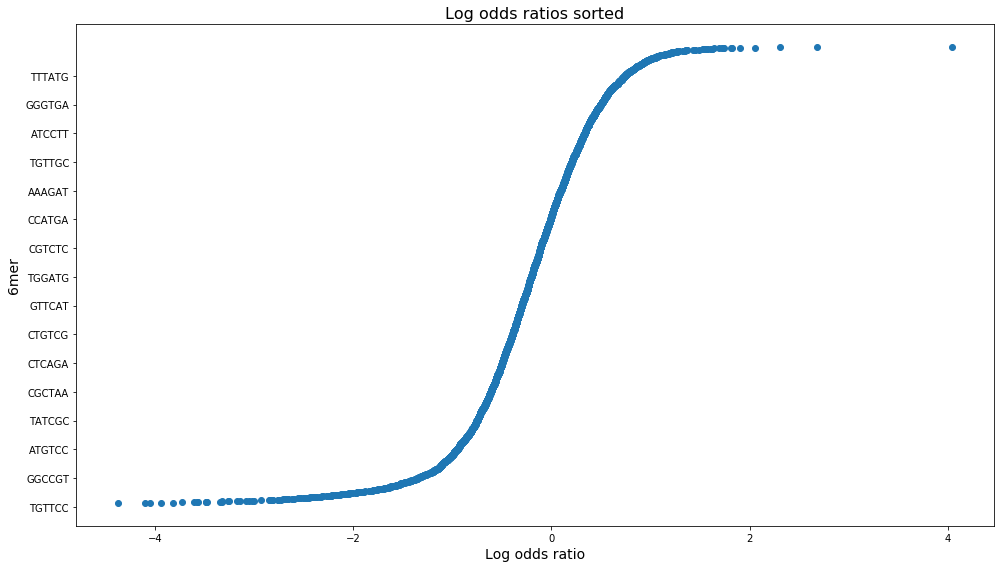

In [5]:
#Problem 1.1
#TODO: Plot the sorted Log odds ratios, and print the smallest and largest values
odds_sort_index = np.argsort(logodds_ratios, axis=0)
sorted_odds = logodds_ratios[odds_sort_index]
sorted_mers = np.array(mer6_list)[odds_sort_index]
print(f'minimum log odds : {sorted_mers[0]}, {sorted_odds[0]}')
print(f'maximum log odds : {sorted_mers[len(sorted_mers) - 1]}, {sorted_odds[len(sorted_odds) - 1]}')


f = plt.figure(figsize=(14,8))
plt.scatter(sorted_odds, sorted_mers)
plt.title("Log odds ratios sorted", fontsize=16)
plt.xlabel('Log odds ratio', fontsize=14)
plt.ylabel('6mer', fontsize=14)
plt.yticks(np.arange(0, len(sorted_mers), step=256))
plt.tight_layout()
plt.show()

In [6]:
#Problem 1.3
#TODO: Split data (matrix X and vector y) into training and test sets. Test set should contain 2,000 data points
split = 8000
trainX = X[:split]
testX = X[split:]
trainY = y[:split]
testY = y[split:]


In [7]:
#Problem 1.3
#TODO: Implement Gradient Descent with KL-divergence gradients for regressing splice site usages

#Helper function for computing log(x / y) in a safe way (whenever x or y is 0).
def safe_kl_log(num, denom) :
    log_vec = np.zeros(num.shape)
    log_vec[(num > 0) & (denom > 0)] = np.log(num[(num > 0) & (denom > 0)] / denom[(num > 0) & (denom > 0)])
    
    return log_vec

def calc_result(X, w, w_0, y_true) :
    y_guesses = np.zeros(y_true.shape)
    tmp = w_0 + X.dot(w)
    for i in range(X.shape[0]):
        y_guesses[i] = 1 / (1 + (math.exp(-tmp.T[i])))
    return y_guesses

#Compute the KL divergence loss (alpha is regularization parameter)
def kl_divergence_loss(X, w, w_0, y_true, alpha=0.0001) :
    #TODO: Implement and return kl divergence loss function L(w, w0, alpha)
    y_guesses = calc_result(X, w, w_0, y_true)
    num_sum = np.sum(y_true * safe_kl_log(y_true, y_guesses) + (np.ones(y_true.shape) - y_true) * safe_kl_log(np.ones(y_true.shape) - y_true, np.ones(y_true.shape) - y_guesses))
    L = num_sum / len(y_guesses) + alpha * np.dot(w,w) / 2
    return L

#Compute the KL divergence gradients for the weight vector w and intercept term w_0 (alpha is regularization parameter)
def kl_divergence_gradients(X, w, w_0, y_true, alpha=0.0001) :
    #TODO: Implement and return kl divergence loss gradients for w and w_0
    y_guesses = calc_result(X, w, w_0, y_true)
    w_grad = X.T.dot((y_guesses - y_true).T).T / len(y_true) + alpha * w
    w0_grad = np.sum(y_guesses - y_true) / len(y_true)
    
    return w_grad, w0_grad

#Gradient Descent algorithm to optimize weights w and w_0
def gradient_descent(X_train, y_train, X_test, y_test, w, w_0, step_size=0.1, alpha=0.0001, max_epochs=2000) :
    
    mean_train_losses = []
    mean_test_losses = []
    for epoch in range(max_epochs) : #Stop after unreasonable # of iterations, in case we never converge
        if epoch % 50 == 1 and len(mean_train_losses) > 0 :
            print('Training epoch = ' + str(epoch))
            print('Training set KL-div = ' + str(round(mean_train_losses[-1], 4)))
            print('Test set KL-div = ' + str(round(mean_test_losses[-1], 4)))
        
        #TODO: Calculate the KL loss and gradients on the training set
        kl_loss_train = kl_divergence_loss(X_train, w, w_0, y_train)
        w_grad, w0_grad = kl_divergence_gradients(X_train, w, w_0, y_train)
        
        #Update your weights w and w_0 based on the gradients
        w = w - step_size * w_grad
        w_0 = w_0 - step_size * w0_grad
        
        #Append your mean train and test loss to 'mean_train_losses' and 'mean_test_losses'
        kl_loss_test = kl_divergence_loss(X_test, w, w_0, y_test)
        mean_train_losses.append(kl_loss_train)
        mean_test_losses.append(kl_loss_test)
        
        # Stop the loop once the training loss stops decreasing significantly
        if len(mean_train_losses) > 1 and mean_train_losses[-1] > mean_train_losses[-2]:
            print(f'woah {mean_train_losses[-1]} > {mean_train_losses[-2]}')
        if len(mean_train_losses) > 1 and mean_train_losses[-1]/mean_train_losses[-2] < alpha:
            break

    print('Gradient descent completed.')
    print('Final training set KL-div = ' + str(round(mean_train_losses[-1], 4)))
    print('Final test set KL-div = ' + str(round(mean_test_losses[-1], 4)))
    
    return w, w_0, mean_train_losses, mean_test_losses

In [8]:
#Problem 1.3
#TODO: Plot training and test set loss (mean KL-div) vs. training iteration
w = np.zeros(trainX.shape[1])
w_0 = 0
w, w_0, mean_train_losses, mean_test_losses = gradient_descent(trainX, trainY, testX, testY, w, w_0)



Training epoch = 1
Training set KL-div = 0.4482
Test set KL-div = 0.4213
Training epoch = 51
Training set KL-div = 0.25
Test set KL-div = 0.259
Training epoch = 101
Training set KL-div = 0.2233
Test set KL-div = 0.2347
Training epoch = 151
Training set KL-div = 0.2064
Test set KL-div = 0.219
Training epoch = 201
Training set KL-div = 0.1943
Test set KL-div = 0.208
Training epoch = 251
Training set KL-div = 0.1851
Test set KL-div = 0.1997
Training epoch = 301
Training set KL-div = 0.1777
Test set KL-div = 0.1933
Training epoch = 351
Training set KL-div = 0.1716
Test set KL-div = 0.188
Training epoch = 401
Training set KL-div = 0.1665
Test set KL-div = 0.1837
Training epoch = 451
Training set KL-div = 0.162
Test set KL-div = 0.1799
Training epoch = 501
Training set KL-div = 0.1581
Test set KL-div = 0.1767
Training epoch = 551
Training set KL-div = 0.1547
Test set KL-div = 0.1738
Training epoch = 601
Training set KL-div = 0.1516
Test set KL-div = 0.1713
Training epoch = 651
Training set K

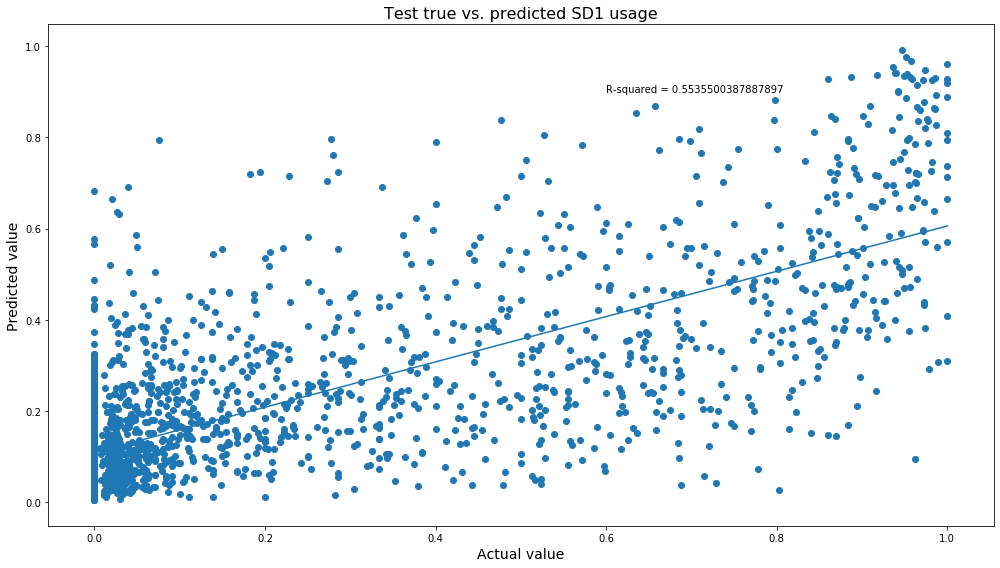

In [13]:

y_guesses_test = calc_result(testX, w, w_0, testY)

#TODO: Scatter plot of true vs. pred SD1 usage on test set, and print R^2 coefficient.

f, ax = plt.subplots(figsize=(14,8))
#plt.scatter(range(len(testY)), y_guesses_test, c='b', label='prediction')
#plt.scatter(range(len(testY)), testY, c='r', label='true value')
plt.scatter(testY, y_guesses_test)
plt.title("Test true vs. predicted SD1 usage", fontsize=16)
plt.xlabel('Actual value', fontsize=14)
plt.ylabel('Predicted value', fontsize=14)
plt.tight_layout()

plt.plot(np.unique(testY), np.poly1d(np.polyfit(testY, y_guesses_test, 1))(np.unique(testY)))
r_squared = pearsonr(testY, y_guesses_test)[0]**2
plt.text(0.6, 0.9, f'R-squared = {r_squared}')

plt.show()



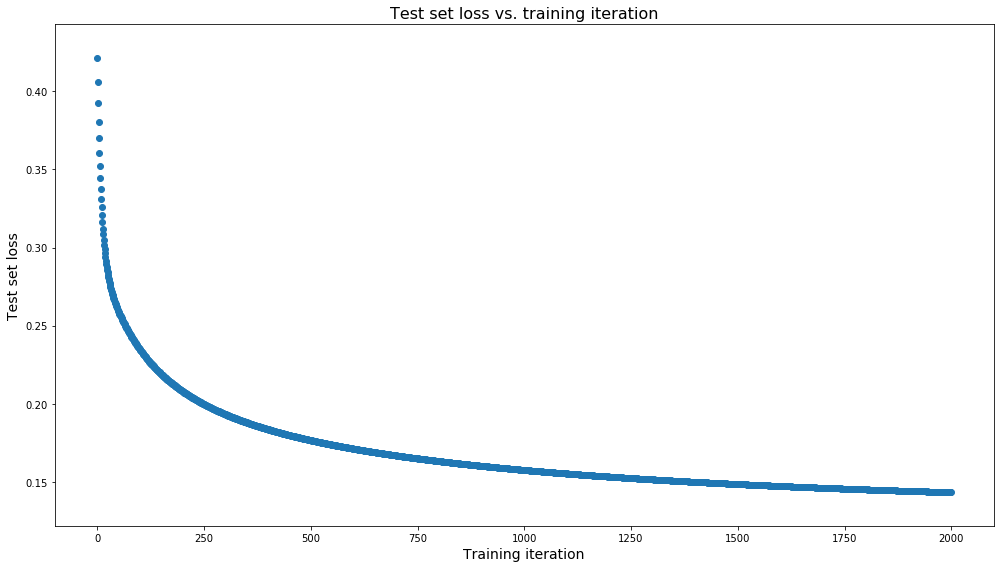

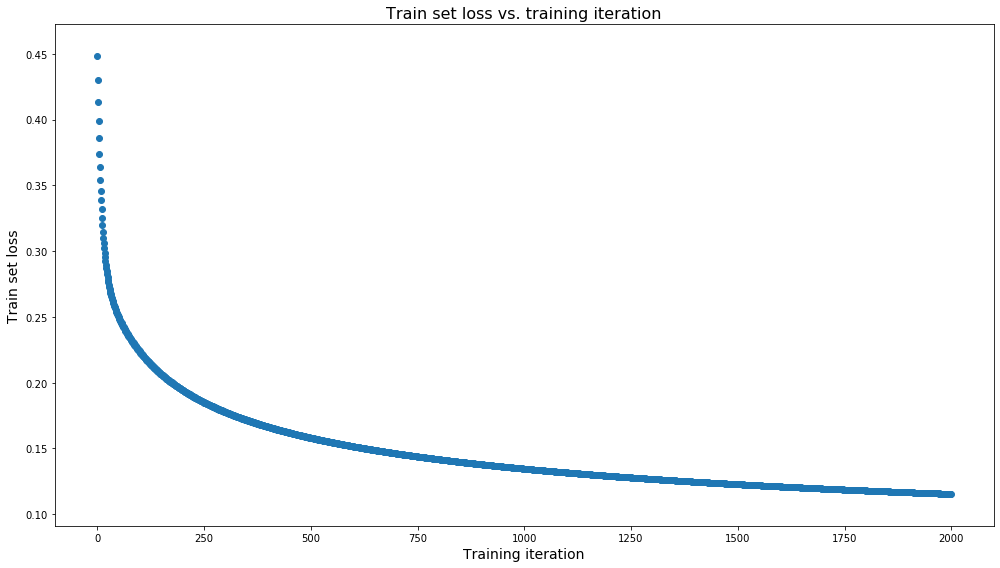

In [14]:

f = plt.figure(figsize=(14,8))
plt.scatter(range(len(mean_test_losses)), mean_test_losses)
plt.title("Test set loss vs. training iteration", fontsize=16)
plt.xlabel('Training iteration', fontsize=14)
plt.ylabel('Test set loss', fontsize=14)
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(14,8))
plt.scatter(range(len(mean_train_losses)), mean_train_losses)
plt.title("Train set loss vs. training iteration", fontsize=16)
plt.xlabel('Training iteration', fontsize=14)
plt.ylabel('Train set loss', fontsize=14)
plt.tight_layout()
plt.show()





In [11]:
#Problem 1.3
w_sort_idx = np.argsort(w)
w_sorted = w[w_sort_idx]
mer6_w_sorted = np.array(mer6_list)[w_sort_idx]
#TODO: Plot the 10 6-mers and corresponding weights of largest magnitude
print('Largest 10')
for i in range(10):
    print(f'{i+1}: {mer6_w_sorted[len(w_sorted) - 1 - i]} = {w_sorted[len(w_sorted) - 1 - i]}')


#TODO: Plot the 10 6-mers and corresponding weights of smallest magnitude
print('\nSmallest 10')
for i in range(10):
    print(f'{i+1}: {mer6_w_sorted[i]} = {w_sorted[i]}')

Largest 10
1: GGGGGG = 0.7516851861509208
2: GGGAGG = 0.5557615127030084
3: GGAGGG = 0.4674845457590094
4: GGGTGG = 0.4607843124294966
5: GGTGGG = 0.443739283141239
6: GGGGGT = 0.43239217172185856
7: AGGGGG = 0.42510180949145804
8: GGGGAG = 0.40557013223742644
9: TGGGGG = 0.39704483654690115
10: GGGGGA = 0.3964454601591616

Smallest 10
1: GGTAAG = -0.4905625206301185
2: CGGTCG = -0.4526635880113442
3: CTTGGA = -0.37691215597236133
4: AGGTAA = -0.3247229520695178
5: CTTGGT = -0.3177554807667483
6: AGAAGA = -0.29436415586639525
7: AAGGTA = -0.28605283456665076
8: GAAGAT = -0.2829213533360671
9: CTTGGC = -0.2752746813347673
10: AAGAAG = -0.2711098799819469
